In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

### Recall vs applied read depth filter

Columns from VCF: CHROM, POS, REF, ALT, QUAL, AD (split into AD_REF and AD ALT), DP, GT, RK_DISCOSNP (from INFO/Rk)

Added columns:
- TYPE: by comparing lengths of REF and ALT in checker.py
- BAM_DP: from intersection of two BED files, 1) generated from BAM using `bedtools genomecov -bga` and 2) from variants.py mutation list.
- TOOL and SAMPLE: user input parameter to checker.py
- TRUE_POS, FALSE_POS, FALSE_NEG: checker.py

*Note:* no DP field present in bcftools' VCF, so filtering is only based on BAM_DP.

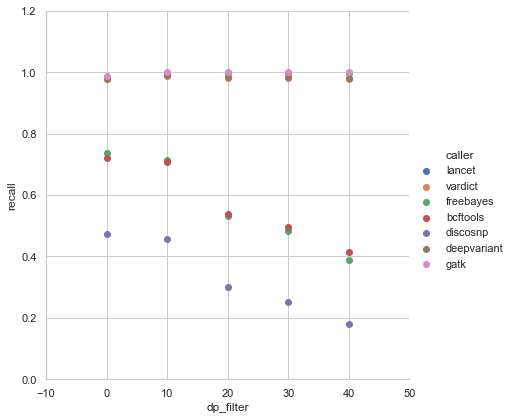

In [339]:
# Filtered on BAM_DP
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,50), ylim=(0,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

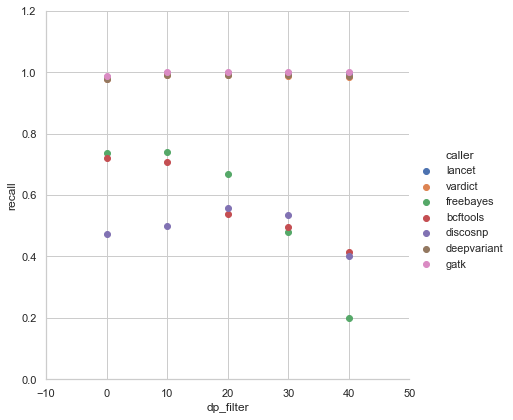

In [340]:
# Filtered on DP
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=dp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,50), ylim=(0,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

#### Input

CSV generated by testing pipeline of all true and false calls from all variant callers (deepvariant, discosnp, freebayes, gatk, lancet, vardict; bcftools included, but DP reporting needs to be fixed)

In [325]:
all_calls_noRDfilter = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/TEST-H37Rv10-3IND_alltools_normalized_dp0_checked.csv')

In [326]:
all_calls_noRDfilter

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,852.97,0.0,15.0,15.0,76,1,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,494.97,2.0,10.0,12.0,75,1,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,1076.97,0.0,20.0,20.0,50,1,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,1466.97,0.0,34.0,34.0,9,1,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,1353.97,0.0,30.0,30.0,42,1,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41812,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,192.00,9.0,48.0,50.0,56,1/1,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
41813,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,171.00,3.0,32.0,35.0,35,1/1,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
41814,NC_000962.3,4409772,C,CGCGTTGCAGCTTTA,INS,101.00,26.0,8.0,36.0,35,0/1,NaN,vardict,TEST-H37Rv10-3IND,0,1,0
41815,NC_000962.3,4410762,C,CCGCAAATAAGCCCGGTGTTGCAA,INS,193.00,9.0,50.0,53.0,51,1/1,NaN,vardict,TEST-H37Rv10-3IND,1,0,0


In [328]:
# no DP or BAM_DP filtering
dp0_sums = {}
for tool in set(all_calls_noRDfilter['TOOL']):
    dp0_sums[tool] = [sum(all_calls_noRDfilter.loc[all_calls_noRDfilter['TOOL'] == tool,'TRUE_POS']),
                      sum(all_calls_noRDfilter.loc[all_calls_noRDfilter['TOOL'] == tool,'FALSE_POS']),
                      sum(all_calls_noRDfilter.loc[all_calls_noRDfilter['TOOL'] == tool,'FALSE_NEG'])]
dp0_df = pd.DataFrame(data=dp0_sums).T
dp0_df.reset_index(inplace=True)
dp0_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
dp0_df['dp_filter'] = 0
dp0_df['recall'] = dp0_df['true_pos'] / (dp0_df['true_pos'] + dp0_df['false_neg'])
dp0_df['precision'] = dp0_df['true_pos'] / (dp0_df['true_pos'] + dp0_df['false_pos'])
dp0_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,4284,9470,72,0,0.983471,0.311473
1,vardict,4263,604,93,0,0.978650,0.875899
2,freebayes,3210,156,1146,0,0.736915,0.953654
3,bcftools,3137,1091,1219,0,0.720156,0.741958
4,discosnp,2066,2,2290,0,0.474288,0.999033
5,deepvariant,4264,2,92,0,0.978880,0.999531
6,gatk,4301,0,55,0,0.987374,1.000000


In [329]:
# BAM_DP >= 10
bamdp10_sums = {}
bamdp10 = all_calls_noRDfilter[all_calls_noRDfilter['BAM_DP'] >= 10]
for tool in set(bamdp10['TOOL']):
    bamdp10_sums[tool] = [sum(bamdp10.loc[bamdp10['TOOL'] == tool,'TRUE_POS']),
                          sum(bamdp10.loc[bamdp10['TOOL'] == tool,'FALSE_POS']),
                          sum(bamdp10.loc[bamdp10['TOOL'] == tool,'FALSE_NEG'])]
bamdp10_df = pd.DataFrame(data=bamdp10_sums).T
bamdp10_df.reset_index(inplace=True)
bamdp10_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
bamdp10_df['dp_filter'] = 10
bamdp10_df['recall'] = bamdp10_df['true_pos'] / (bamdp10_df['true_pos'] + bamdp10_df['false_neg'])
bamdp10_df['precision'] = bamdp10_df['true_pos'] / (bamdp10_df['true_pos'] + bamdp10_df['false_pos'])
bamdp10_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,3807,9464,10,10,0.997380,0.286866
1,vardict,3774,600,43,10,0.988735,0.862826
2,freebayes,2725,153,1092,10,0.713911,0.946838
3,bcftools,2696,579,1121,10,0.706314,0.823206
4,discosnp,1740,2,2077,10,0.455855,0.998852
5,deepvariant,3777,1,40,10,0.989521,0.999735
6,gatk,3814,0,3,10,0.999214,1.000000


In [330]:
# BAM_DP >= 20
bamdp20_sums = {}
bamdp20 = all_calls_noRDfilter[all_calls_noRDfilter['BAM_DP'] >= 20]
for tool in set(bamdp20['TOOL']):
    bamdp20_sums[tool] = [sum(bamdp20.loc[bamdp20['TOOL'] == tool,'TRUE_POS']),
                          sum(bamdp20.loc[bamdp20['TOOL'] == tool,'FALSE_POS']),
                          sum(bamdp20.loc[bamdp20['TOOL'] == tool,'FALSE_NEG'])]
bamdp20_df = pd.DataFrame(data=bamdp20_sums).T
bamdp20_df.reset_index(inplace=True)
bamdp20_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
bamdp20_df['dp_filter'] = 20
bamdp20_df['recall'] = bamdp20_df['true_pos'] / (bamdp20_df['true_pos'] + bamdp20_df['false_neg'])
bamdp20_df['precision'] = bamdp20_df['true_pos'] / (bamdp20_df['true_pos'] + bamdp20_df['false_pos'])
bamdp20_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,2312,9438,6,20,0.997412,0.196766
1,vardict,2275,594,43,20,0.981450,0.792959
2,freebayes,1233,151,1085,20,0.531924,0.890896
3,bcftools,1250,237,1068,20,0.539258,0.840619
4,discosnp,694,2,1624,20,0.299396,0.997126
5,deepvariant,2282,1,36,20,0.984469,0.999562
6,gatk,2316,0,2,20,0.999137,1.000000


In [331]:
# BAM_DP >= 30
bamdp30_sums = {}
bamdp30 = all_calls_noRDfilter[all_calls_noRDfilter['BAM_DP'] >= 30]
for tool in set(bamdp30['TOOL']):
    bamdp30_sums[tool] = [sum(bamdp30.loc[bamdp30['TOOL'] == tool,'TRUE_POS']),
                          sum(bamdp30.loc[bamdp30['TOOL'] == tool,'FALSE_POS']),
                          sum(bamdp30.loc[bamdp30['TOOL'] == tool,'FALSE_NEG'])]
bamdp30_df = pd.DataFrame(data=bamdp30_sums).T
bamdp30_df.reset_index(inplace=True)
bamdp30_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
bamdp30_df['dp_filter'] = 30
bamdp30_df['recall'] = bamdp30_df['true_pos'] / (bamdp30_df['true_pos'] + bamdp30_df['false_neg'])
bamdp30_df['precision'] = bamdp30_df['true_pos'] / (bamdp30_df['true_pos'] + bamdp30_df['false_pos'])
bamdp30_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,2081,8797,5,30,0.997603,0.191304
1,vardict,2044,560,42,30,0.979866,0.784946
2,freebayes,1010,143,1076,30,0.484180,0.875976
3,bcftools,1034,50,1052,30,0.495686,0.953875
4,discosnp,523,2,1563,30,0.250719,0.996190
5,deepvariant,2051,0,35,30,0.983221,1.000000
6,gatk,2085,0,1,30,0.999521,1.000000


In [332]:
# BAM_DP >= 40
bamdp40_sums = {}
bamdp40 = all_calls_noRDfilter[all_calls_noRDfilter['BAM_DP'] >= 40]
for tool in set(bamdp40['TOOL']):
    bamdp40_sums[tool] = [sum(bamdp40.loc[bamdp40['TOOL'] == tool,'TRUE_POS']),
                          sum(bamdp40.loc[bamdp40['TOOL'] == tool,'FALSE_POS']),
                          sum(bamdp40.loc[bamdp40['TOOL'] == tool,'FALSE_NEG'])]
bamdp40_df = pd.DataFrame(data=bamdp40_sums).T
bamdp40_df.reset_index(inplace=True)
bamdp40_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
bamdp40_df['dp_filter'] = 40
bamdp40_df['recall'] = bamdp40_df['true_pos'] / (bamdp40_df['true_pos'] + bamdp40_df['false_neg'])
bamdp40_df['precision'] = bamdp40_df['true_pos'] / (bamdp40_df['true_pos'] + bamdp40_df['false_pos'])
bamdp40_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,1635,5387,2,40,0.998778,0.232840
1,vardict,1598,396,39,40,0.976176,0.801404
2,freebayes,634,113,1003,40,0.387294,0.848728
3,bcftools,676,24,961,40,0.412951,0.965714
4,discosnp,297,0,1340,40,0.181429,1.000000
5,deepvariant,1607,0,30,40,0.981674,1.000000
6,gatk,1637,0,0,40,1.000000,1.000000


In [333]:
bamdp_summary_df = pd.concat([dp0_df, bamdp10_df, bamdp20_df, bamdp30_df, bamdp40_df], ignore_index=True)
bamdp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,4284,9470,72,0,0.983471,0.311473
1,vardict,4263,604,93,0,0.978650,0.875899
2,freebayes,3210,156,1146,0,0.736915,0.953654
3,bcftools,3137,1091,1219,0,0.720156,0.741958
4,discosnp,2066,2,2290,0,0.474288,0.999033
5,deepvariant,4264,2,92,0,0.978880,0.999531
6,gatk,4301,0,55,0,0.987374,1.000000
7,lancet,3807,9464,10,10,0.997380,0.286866
8,vardict,3774,600,43,10,0.988735,0.862826
9,freebayes,2725,153,1092,10,0.713911,0.946838


In [334]:
dp10_sums = {}
# DP >= 10
dp10 = all_calls_noRDfilter[(all_calls_noRDfilter['DP'] >= 10) | (all_calls_noRDfilter['DP'].isna() & (all_calls_noRDfilter['BAM_DP'] >= 10))]
for tool in set(dp10['TOOL']):
    dp10_sums[tool] = [sum(dp10.loc[dp10['TOOL'] == tool,'TRUE_POS']),
                       sum(dp10.loc[dp10['TOOL'] == tool,'FALSE_POS']),
                       sum(dp10.loc[dp10['TOOL'] == tool,'FALSE_NEG'])]
dp10_df = pd.DataFrame(data=dp10_sums).T
dp10_df.reset_index(inplace=True)
dp10_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
dp10_df['dp_filter'] = 10
dp10_df['recall'] = dp10_df['true_pos'] / (dp10_df['true_pos'] + dp10_df['false_neg'])
dp10_df['precision'] = dp10_df['true_pos'] / (dp10_df['true_pos'] + dp10_df['false_pos'])
dp10_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,4249,9296,10,10,0.997652,0.313695
1,vardict,4255,598,43,10,0.989995,0.876777
2,freebayes,3089,151,1092,10,0.738818,0.953395
3,bcftools,2696,579,1121,10,0.706314,0.823206
4,discosnp,2066,2,2077,10,0.498672,0.999033
5,deepvariant,4258,1,40,10,0.990693,0.999765
6,gatk,4125,0,3,10,0.999273,1.000000


In [335]:
# DP >= 20
dp20_sums = {}
dp20 = all_calls_noRDfilter[(all_calls_noRDfilter['DP'] >= 20) | (all_calls_noRDfilter['DP'].isna() & (all_calls_noRDfilter['BAM_DP'] >= 20))]
for tool in set(dp20['TOOL']):
    dp20_sums[tool] = [sum(dp20.loc[dp20['TOOL'] == tool,'TRUE_POS']),
                       sum(dp20.loc[dp20['TOOL'] == tool,'FALSE_POS']),
                       sum(dp20.loc[dp20['TOOL'] == tool,'FALSE_NEG'])]
dp20_df = pd.DataFrame(data=dp20_sums).T
dp20_df.reset_index(inplace=True)
dp20_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
dp20_df['dp_filter'] = 20
dp20_df['recall'] = dp20_df['true_pos'] / (dp20_df['true_pos'] + dp20_df['false_neg'])
dp20_df['precision'] = dp20_df['true_pos'] / (dp20_df['true_pos'] + dp20_df['false_pos'])
dp20_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,3976,8740,6,20,0.998493,0.312677
1,vardict,4211,592,43,20,0.989892,0.876744
2,freebayes,2175,95,1085,20,0.667178,0.958150
3,bcftools,1250,237,1068,20,0.539258,0.840619
4,discosnp,2054,2,1624,20,0.558456,0.999027
5,deepvariant,4237,1,36,20,0.991575,0.999764
6,gatk,3182,0,2,20,0.999372,1.000000


In [336]:
# DP >= 30
dp30_sums = {}
dp30 = all_calls_noRDfilter[(all_calls_noRDfilter['DP'] >= 30) | (all_calls_noRDfilter['DP'].isna() & (all_calls_noRDfilter['BAM_DP'] >= 30))]
for tool in set(dp30['TOOL']):
    dp30_sums[tool] = [sum(dp30.loc[dp30['TOOL'] == tool,'TRUE_POS']),
                       sum(dp30.loc[dp30['TOOL'] == tool,'FALSE_POS']),
                       sum(dp30.loc[dp30['TOOL'] == tool,'FALSE_NEG'])]
dp30_df = pd.DataFrame(data=dp30_sums).T
dp30_df.reset_index(inplace=True)
dp30_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
dp30_df['dp_filter'] = 30
dp30_df['recall'] = dp30_df['true_pos'] / (dp30_df['true_pos'] + dp30_df['false_neg'])
dp30_df['precision'] = dp30_df['true_pos'] / (dp30_df['true_pos'] + dp30_df['false_pos'])
dp30_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,3028,5971,5,30,0.998351,0.336482
1,vardict,3671,588,42,30,0.988688,0.861939
2,freebayes,986,27,1076,30,0.478177,0.973346
3,bcftools,1034,50,1052,30,0.495686,0.953875
4,discosnp,1808,2,1563,30,0.536339,0.998895
5,deepvariant,3923,1,35,30,0.991157,0.999745
6,gatk,1879,0,1,30,0.999468,1.000000


In [337]:
# DP >= 40
dp40_sums = {}
dp40 = all_calls_noRDfilter[(all_calls_noRDfilter['DP'] >= 40) | (all_calls_noRDfilter['DP'].isna() & (all_calls_noRDfilter['BAM_DP'] >= 40))]
for tool in set(dp40['TOOL']):
    dp40_sums[tool] = [sum(dp40.loc[dp40['TOOL'] == tool,'TRUE_POS']),
                       sum(dp40.loc[dp40['TOOL'] == tool,'FALSE_POS']),
                       sum(dp40.loc[dp40['TOOL'] == tool,'FALSE_NEG'])]
dp40_df = pd.DataFrame(data=dp40_sums).T
dp40_df.reset_index(inplace=True)
dp40_df.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
dp40_df['dp_filter'] = 40
dp40_df['recall'] = dp40_df['true_pos'] / (dp40_df['true_pos'] + dp40_df['false_neg'])
dp40_df['precision'] = dp40_df['true_pos'] / (dp40_df['true_pos'] + dp40_df['false_pos'])
dp40_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,1622,1798,2,40,0.998768,0.474269
1,vardict,2386,516,39,40,0.983918,0.822192
2,freebayes,250,9,1003,40,0.199521,0.965251
3,bcftools,676,24,961,40,0.412951,0.965714
4,discosnp,894,2,1340,40,0.400179,0.997768
5,deepvariant,2599,0,30,40,0.988589,1.000000
6,gatk,525,0,0,40,1.000000,1.000000


In [338]:
dp_summary_df = pd.concat([dp0_df, dp10_df, dp20_df, dp30_df, dp40_df], ignore_index=True)
dp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision
0,lancet,4284,9470,72,0,0.983471,0.311473
1,vardict,4263,604,93,0,0.978650,0.875899
2,freebayes,3210,156,1146,0,0.736915,0.953654
3,bcftools,3137,1091,1219,0,0.720156,0.741958
4,discosnp,2066,2,2290,0,0.474288,0.999033
5,deepvariant,4264,2,92,0,0.978880,0.999531
6,gatk,4301,0,55,0,0.987374,1.000000
7,lancet,4249,9296,10,10,0.997652,0.313695
8,vardict,4255,598,43,10,0.989995,0.876777
9,freebayes,3089,151,1092,10,0.738818,0.953395


#### Input
The input csv file is a concatenation of the `TEST-*_stats.csv` file output from `checker.py` (i.e., the last steps in `04_check_variants.sh`), which provides true positive, false positive, false negative, precision, and recall values after variant-calling.

### Without read depth filtering

In [2]:
stats = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/20210706_alltools_no_header_stats.csv', header=None)

In [3]:
stats.rename(columns={0: 'file_prefix', 1: 'true_pos', 2: 'true_pos_snp', 3: 'true_pos_ind', 
                      4: 'false_pos', 5: 'false_pos_snp', 6: 'false_pos_ind', 
                      7: 'false_neg', 8: 'false_neg_snp', 9: 'false_neg_ind',
                      10: 'precision', 11: 'recall'}, inplace=True)

In [4]:
stats.loc[stats['recall'] == '.' , 'recall'] = np.nan
stats.loc[stats['precision'] == '.' , 'precision'] = np.nan
stats['recall'] = pd.to_numeric(stats['recall'])
stats['precision'] = pd.to_numeric(stats['precision'])

In [5]:
stats['true_pos'] = pd.to_numeric(stats['true_pos'])
stats['true_pos_snp'] = pd.to_numeric(stats['true_pos_snp'])
stats['true_pos_ind'] = pd.to_numeric(stats['true_pos_ind'])
stats['false_pos'] = pd.to_numeric(stats['false_pos'])
stats['false_pos_snp'] = pd.to_numeric(stats['false_pos_snp'])
stats['false_pos_ind'] = pd.to_numeric(stats['false_pos_ind'])
stats['false_neg'] = pd.to_numeric(stats['false_neg'])
stats['false_neg_snp'] = pd.to_numeric(stats['false_neg_snp'])
stats['false_neg_ind'] = pd.to_numeric(stats['false_neg_ind'])

In [6]:
num_snp = {'TEST-H37Rv20snps': 20, 'TEST-H37Rv200snps': 200, 'TEST-H37Rv2000snps': 2000, 'TEST-H37Rv20003snps': 20003, 'TEST-MTBREF': 0, 
            'TEST-MTBVAR1': 1048, 'TEST-MTBVAR2': 3277, 'TEST-MTBVAR3': 11, 'TEST-MTBVAR4': 149, 'TEST-MTBVAR5': 1480, 'TEST-MTBVAR6': 16468,
            'TEST-H37Rv10-3indels': 0, 'TEST-H37Rv10-4indels': 0, 'TEST-H37Rv10-5indels': 0, 'TEST-H37Rv10-6indels': 0,
            'TEST-H37Rv10-3medindels': 0, 'TEST-H37Rv10-4medindels': 0, 'TEST-H37Rv10-5medindels': 0, 'TEST-H37Rv10-6medindels': 0,
            'TEST-H37Rv10-3SNP': 4358, 'TEST-H37Rv10-4SNP': 442, 'TEST-H37Rv10-3IND': 0, 'TEST-H37Rv10-4IND': 0}
num_indel = {'TEST-H37Rv20snps': 0, 'TEST-H37Rv200snps': 0, 'TEST-H37Rv2000snps': 0, 'TEST-H37Rv20003snps': 0, 'TEST-MTBREF': 0, 
             'TEST-MTBVAR1': 3317, 'TEST-MTBVAR2': 1120, 'TEST-MTBVAR3': 9, 'TEST-MTBVAR4': 51, 'TEST-MTBVAR5': 524, 'TEST-MTBVAR6': 5472,
             'TEST-H37Rv10-3indels': 4294, 'TEST-H37Rv10-4indels': 439, 'TEST-H37Rv10-5indels': 44, 'TEST-H37Rv10-6indels': 4,
             'TEST-H37Rv10-3medindels': 4306, 'TEST-H37Rv10-4medindels': 439, 'TEST-H37Rv10-5medindels': 44, 'TEST-H37Rv10-6medindels': 4,
             'TEST-H37Rv10-3SNP': 0, 'TEST-H37Rv10-4SNP': 0, 'TEST-H37Rv10-3IND': 4356, 'TEST-H37Rv10-4IND': 440}

In [7]:
stats['dataset'] = [name.split('_')[0] for name in stats['file_prefix']]
stats['tool'] = [name.split('_')[-2] for name in stats['file_prefix']]
stats.loc[stats['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats.loc[stats['tool'] == 'normalized',:]['file_prefix']]
stats.loc[stats['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats.loc[stats['tool'] == 'normalized',:]['file_prefix']]
stats['num_snp'] = [int(num_snp[ds]) for ds in stats['dataset']]
stats['num_indel'] = [int(num_indel[ds]) for ds in stats['dataset']]
stats['total_mutations'] = stats['num_snp'] + stats['num_indel']
stats['low_cov_mutations_filtered'] = stats['total_mutations'] - stats['true_pos'] - stats['false_neg']

In [8]:
stats['filtered_total_mutations'] = stats['total_mutations'] - stats['low_cov_mutations_filtered']

In [9]:
stats['snp_density'] = stats['num_snp'] / 4411532

In [10]:
stats['indel_density'] = stats['num_indel'] / 4411532

In [11]:
stats['indel_snp_ratio'] = round(stats['num_indel']/stats['num_snp'], 2)

In [12]:
stats

,file_prefix,true_pos,true_pos_snp,true_pos_ind,false_pos,false_pos_snp,false_pos_ind,false_neg,false_neg_snp,false_neg_ind,...,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3IND_bcftools_normalized,3137,0,3137,1091,1085,6,1219,1219,0,...,TEST-H37Rv10-3IND,bcftools,0,4356,4356,0,4356,0.000000,0.000987,inf
1,TEST-H37Rv10-3SNP_bcftools_normalized,4319,4319,0,0,0,0,39,39,0,...,TEST-H37Rv10-3SNP,bcftools,4358,0,4358,0,4358,0.000988,0.000000,0.0
2,TEST-H37Rv10-4IND_bcftools_normalized,331,0,331,122,122,0,109,109,0,...,TEST-H37Rv10-4IND,bcftools,0,440,440,0,440,0.000000,0.000100,inf
3,TEST-H37Rv10-3IND_deepvariant_normalized_PASS,4264,0,4264,2,1,1,92,92,0,...,TEST-H37Rv10-3IND,deepvariant,0,4356,4356,0,4356,0.000000,0.000987,inf
4,TEST-H37Rv10-3SNP_deepvariant_normalized_PASS,4318,4318,0,0,0,0,40,40,0,...,TEST-H37Rv10-3SNP,deepvariant,4358,0,4358,0,4358,0.000988,0.000000,0.0
5,TEST-H37Rv10-4IND_deepvariant_normalized_PASS,432,0,432,1,1,0,8,8,0,...,TEST-H37Rv10-4IND,deepvariant,0,440,440,0,440,0.000000,0.000100,inf
6,TEST-H37Rv10-3IND_delly_normalized,0,0,0,1190,0,1190,4356,4356,0,...,TEST-H37Rv10-3IND,delly,0,4356,4356,0,4356,0.000000,0.000987,inf
7,TEST-H37Rv10-3SNP_delly_normalized,0,0,0,0,0,0,4358,4358,0,...,TEST-H37Rv10-3SNP,delly,4358,0,4358,0,4358,0.000988,0.000000,0.0
8,TEST-H37Rv10-4IND_delly_normalized,0,0,0,126,0,126,440,440,0,...,TEST-H37Rv10-4IND,delly,0,440,440,0,440,0.000000,0.000100,inf
9,TEST-H37Rv10-3IND_discosnp-edit_normalized_PAS...,2066,0,2066,2,2,0,2290,2290,0,...,TEST-H37Rv10-3IND,discosnp,0,4356,4356,0,4356,0.000000,0.000987,inf


In [ ]:
# remove duplicate tools
#stats_noHC = stats[stats['tool'] != 'HaplotypeCaller']
#stats_noduptools = stats_noHC[stats['tool'] != 'discosnp-edit']

In [13]:
stats_SNPonly = stats[stats['num_indel'] == 0]

In [14]:
stats_indelonly = stats[stats['num_snp'] == 0]

In [15]:
stats_SNPonly

,file_prefix,true_pos,true_pos_snp,true_pos_ind,false_pos,false_pos_snp,false_pos_ind,false_neg,false_neg_snp,false_neg_ind,...,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
1,TEST-H37Rv10-3SNP_bcftools_normalized,4319,4319,0,0,0,0,39,39,0,...,TEST-H37Rv10-3SNP,bcftools,4358,0,4358,0,4358,0.000988,0.0,0.0
4,TEST-H37Rv10-3SNP_deepvariant_normalized_PASS,4318,4318,0,0,0,0,40,40,0,...,TEST-H37Rv10-3SNP,deepvariant,4358,0,4358,0,4358,0.000988,0.0,0.0
7,TEST-H37Rv10-3SNP_delly_normalized,0,0,0,0,0,0,4358,4358,0,...,TEST-H37Rv10-3SNP,delly,4358,0,4358,0,4358,0.000988,0.0,0.0
10,TEST-H37Rv10-3SNP_discosnp-edit_normalized_PAS...,4210,4210,0,3,2,1,148,148,0,...,TEST-H37Rv10-3SNP,discosnp,4358,0,4358,0,4358,0.000988,0.0,0.0
13,TEST-H37Rv10-3SNP_freebayes_normalized,4318,4318,0,1,1,0,40,40,0,...,TEST-H37Rv10-3SNP,freebayes,4358,0,4358,0,4358,0.000988,0.0,0.0
16,TEST-H37Rv10-3SNP_gatk_normalized,4316,4316,0,0,0,0,42,42,0,...,TEST-H37Rv10-3SNP,gatk,4358,0,4358,0,4358,0.000988,0.0,0.0
19,TEST-H37Rv10-3SNP_lancet_normalized,4242,4242,0,0,0,0,116,116,0,...,TEST-H37Rv10-3SNP,lancet,4358,0,4358,0,4358,0.000988,0.0,0.0
21,TEST-H37Rv10-3SNP_vardict_normalized,4318,4318,0,0,0,0,40,40,0,...,TEST-H37Rv10-3SNP,vardict,4358,0,4358,0,4358,0.000988,0.0,0.0
24,TEST-H37Rv10-4SNP_vardict_normalized,430,430,0,0,0,0,12,12,0,...,TEST-H37Rv10-4SNP,vardict,442,0,442,0,442,0.000100,0.0,0.0
25,TEST-H37Rv10-4SNP_lancet_normalized,425,425,0,0,0,0,17,17,0,...,TEST-H37Rv10-4SNP,lancet,442,0,442,0,442,0.000100,0.0,0.0


In [16]:
stats_indelonly

,file_prefix,true_pos,true_pos_snp,true_pos_ind,false_pos,false_pos_snp,false_pos_ind,false_neg,false_neg_snp,false_neg_ind,...,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3IND_bcftools_normalized,3137,0,3137,1091,1085,6,1219,1219,0,...,TEST-H37Rv10-3IND,bcftools,0,4356,4356,0,4356,0.0,0.000987,inf
2,TEST-H37Rv10-4IND_bcftools_normalized,331,0,331,122,122,0,109,109,0,...,TEST-H37Rv10-4IND,bcftools,0,440,440,0,440,0.0,0.000100,inf
3,TEST-H37Rv10-3IND_deepvariant_normalized_PASS,4264,0,4264,2,1,1,92,92,0,...,TEST-H37Rv10-3IND,deepvariant,0,4356,4356,0,4356,0.0,0.000987,inf
5,TEST-H37Rv10-4IND_deepvariant_normalized_PASS,432,0,432,1,1,0,8,8,0,...,TEST-H37Rv10-4IND,deepvariant,0,440,440,0,440,0.0,0.000100,inf
6,TEST-H37Rv10-3IND_delly_normalized,0,0,0,1190,0,1190,4356,4356,0,...,TEST-H37Rv10-3IND,delly,0,4356,4356,0,4356,0.0,0.000987,inf
8,TEST-H37Rv10-4IND_delly_normalized,0,0,0,126,0,126,440,440,0,...,TEST-H37Rv10-4IND,delly,0,440,440,0,440,0.0,0.000100,inf
9,TEST-H37Rv10-3IND_discosnp-edit_normalized_PAS...,2066,0,2066,2,2,0,2290,2290,0,...,TEST-H37Rv10-3IND,discosnp,0,4356,4356,0,4356,0.0,0.000987,inf
11,TEST-H37Rv10-4IND_discosnp-edit_normalized_PAS...,236,0,236,2,2,0,204,204,0,...,TEST-H37Rv10-4IND,discosnp,0,440,440,0,440,0.0,0.000100,inf
12,TEST-H37Rv10-3IND_freebayes_normalized,3210,0,3210,156,11,110,1146,1146,0,...,TEST-H37Rv10-3IND,freebayes,0,4356,4356,0,4356,0.0,0.000987,inf
14,TEST-H37Rv10-4IND_freebayes_normalized,344,0,344,12,3,9,96,96,0,...,TEST-H37Rv10-4IND,freebayes,0,440,440,0,440,0.0,0.000100,inf


### SNPs only

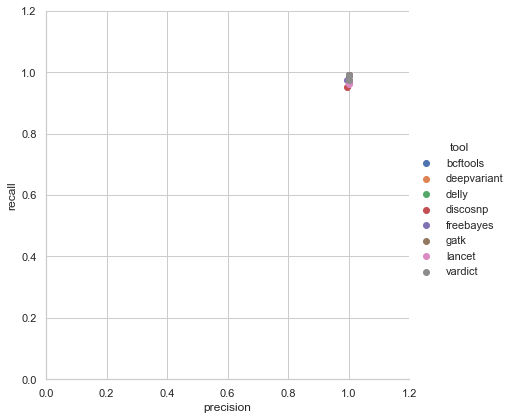

In [17]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_SNPonly, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

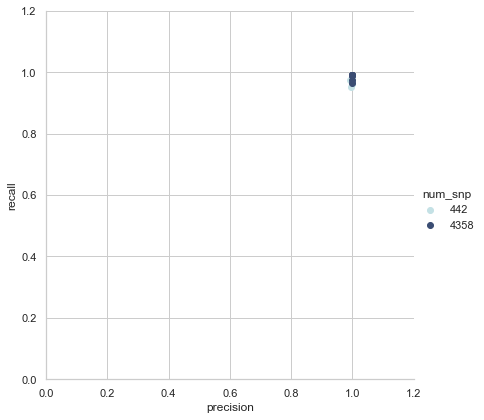

In [18]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_SNPonly, hue='num_snp', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### Indels only

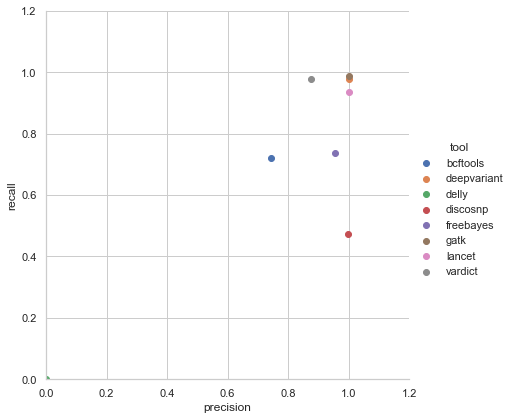

In [29]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_indelonly[stats_indelonly.dataset == 'TEST-H37Rv10-3IND'], hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

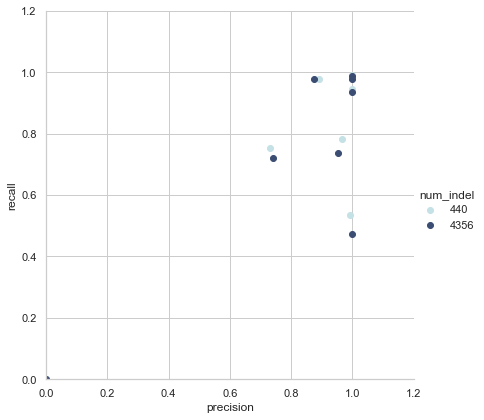

In [20]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_indelonly, hue='num_indel', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### WITH read depth>=10 filtering

In [21]:
stats_dp10 = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/20210709_alltools_dp10_stats.csv', header=None)

In [22]:
stats_dp10.rename(columns={0: 'file_prefix', 1: 'true_pos', 2: 'true_pos_snp', 3: 'true_pos_ind', 
                      4: 'false_pos', 5: 'false_pos_snp', 6: 'false_pos_ind', 
                      7: 'false_neg', 8: 'false_neg_snp', 9: 'false_neg_ind',
                      10: 'precision', 11: 'recall'}, inplace=True)
stats_dp10.loc[stats_dp10['recall'] == '.' , 'recall'] = np.nan
stats_dp10.loc[stats_dp10['precision'] == '.' , 'precision'] = np.nan
stats_dp10['recall'] = pd.to_numeric(stats_dp10['recall'])
stats_dp10['precision'] = pd.to_numeric(stats_dp10['precision'])
stats_dp10['true_pos'] = pd.to_numeric(stats_dp10['true_pos'])
stats_dp10['true_pos_snp'] = pd.to_numeric(stats_dp10['true_pos_snp'])
stats_dp10['true_pos_ind'] = pd.to_numeric(stats_dp10['true_pos_ind'])
stats_dp10['false_pos'] = pd.to_numeric(stats_dp10['false_pos'])
stats_dp10['false_pos_snp'] = pd.to_numeric(stats_dp10['false_pos_snp'])
stats_dp10['false_pos_ind'] = pd.to_numeric(stats_dp10['false_pos_ind'])
stats_dp10['false_neg'] = pd.to_numeric(stats_dp10['false_neg'])
stats_dp10['false_neg_snp'] = pd.to_numeric(stats_dp10['false_neg_snp'])
stats_dp10['false_neg_ind'] = pd.to_numeric(stats_dp10['false_neg_ind'])
stats_dp10['dataset'] = [name.split('_')[0] for name in stats_dp10['file_prefix']]
stats_dp10['tool'] = [name.split('_')[-2] for name in stats_dp10['file_prefix']]
stats_dp10.loc[stats_dp10['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_dp10.loc[stats_dp10['tool'] == 'normalized',:]['file_prefix']]
stats_dp10.loc[stats_dp10['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_dp10.loc[stats_dp10['tool'] == 'normalized',:]['file_prefix']]
stats_dp10['num_snp'] = [int(num_snp[ds]) for ds in stats_dp10['dataset']]
stats_dp10['num_indel'] = [int(num_indel[ds]) for ds in stats_dp10['dataset']]
stats_dp10['total_mutations'] = stats_dp10['num_snp'] + stats_dp10['num_indel']
stats_dp10['low_cov_mutations_filtered'] = stats_dp10['total_mutations'] - stats_dp10['true_pos'] - stats_dp10['false_neg']
stats_dp10['filtered_total_mutations'] = stats_dp10['total_mutations'] - stats_dp10['low_cov_mutations_filtered']
stats_dp10['snp_density'] = stats_dp10['num_snp'] / 4411532
stats_dp10['indel_density'] = stats_dp10['num_indel'] / 4411532
stats_dp10['indel_snp_ratio'] = round(stats_dp10['num_indel']/stats_dp10['num_snp'], 2)
stats_dp10_SNPonly = stats_dp10[stats_dp10['num_indel'] == 0]
stats_dp10_indelonly = stats_dp10[stats_dp10['num_snp'] == 0]

### SNPs only (filtered)

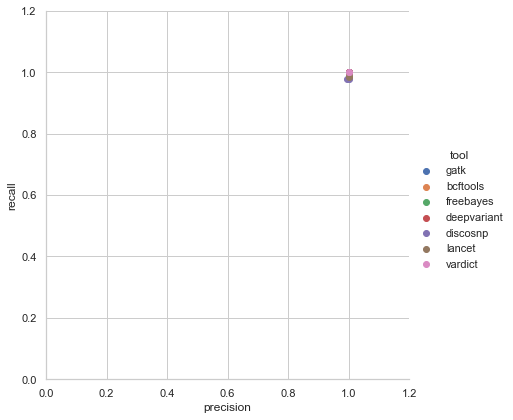

In [23]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_dp10_SNPonly, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

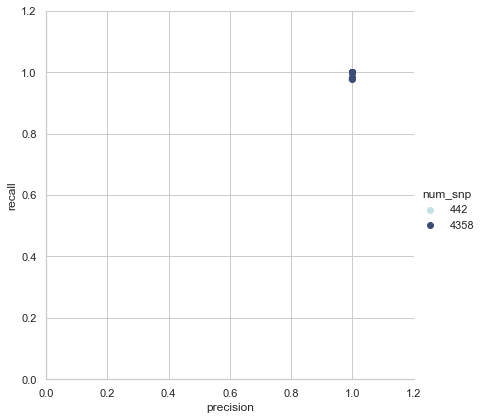

In [24]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_dp10_SNPonly, hue='num_snp', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### Indels only (filtered)

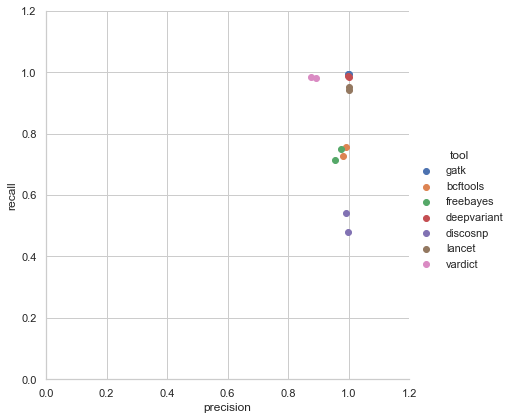

In [25]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_dp10_indelonly, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

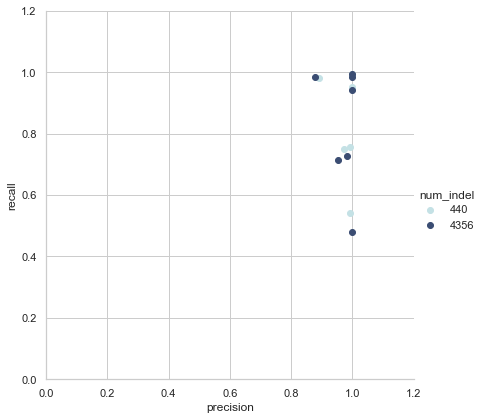

In [26]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_dp10_indelonly, hue='num_indel', palette='ch:r=-.2,d=.3', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

## WIP
### 7/7/2021: Not yet updated with new datasets

In [105]:
# Indels 1-20bp only
smallindels = ['TEST-H37Rv10-3indels', 'TEST-H37Rv10-4indels', 'TEST-H37Rv10-5indels', 'TEST-H37Rv10-6indels']
# Indels 15-50bp only
medindels = ['TEST-H37Rv10-3medindels', 'TEST-H37Rv10-4medindels', 'TEST-H37Rv10-5medindels', 'TEST-H37Rv10-6medindels']

In [106]:
smallindels_df = stats_indelonly[stats_indelonly['dataset'] == smallindels[0]]
smallindels_df = pd.concat([smallindels_df, stats_indelonly[stats_indelonly['dataset'] == smallindels[1]],
                           stats_indelonly[stats_indelonly['dataset'] == smallindels[2]], stats_indelonly[stats_indelonly['dataset'] == smallindels[3]]])
smallindels_df

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,1894,1552,761,0.549623,0.713371,TEST-H37Rv10-3indels,discosnp,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,2654,2613,1,0.503892,0.999623,TEST-H37Rv10-3indels,bcftools,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,2653,1606,2,0.622916,0.999247,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,2655,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,2603,1649,52,0.612183,0.980414,TEST-H37Rv10-3indels,freebayes,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
5,TEST-H37Rv10-3indels_mq10_gatk_normalized,2655,1599,0,0.624118,1.000000,TEST-H37Rv10-3indels,gatk,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
6,TEST-H37Rv10-3indels_mq10_lancet_normalized,2623,1565,32,0.626313,0.987947,TEST-H37Rv10-3indels,lancet,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
7,TEST-H37Rv10-3indels_mq10_vardict_normalized,2655,1988,0,0.571829,1.000000,TEST-H37Rv10-3indels,vardict,0,4294,4294,1639,2655,0.0,9.733580e-04,inf
10,TEST-H37Rv10-4indels_discosnp-edit_normalized_...,223,142,73,0.610959,0.753378,TEST-H37Rv10-4indels,discosnp,0,439,439,143,296,0.0,9.951192e-05,inf
11,TEST-H37Rv10-4indels_mq10_bcftools_normalized,296,240,0,0.552239,1.000000,TEST-H37Rv10-4indels,bcftools,0,439,439,143,296,0.0,9.951192e-05,inf


In [107]:
medindels_df = stats_indelonly[stats_indelonly['dataset'] == medindels[0]]
medindels_df = pd.concat([medindels_df, stats_indelonly[stats_indelonly['dataset'] == medindels[1]],
                           stats_indelonly[stats_indelonly['dataset'] == medindels[2]], stats_indelonly[stats_indelonly['dataset'] == medindels[3]]])
medindels_df

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
8,TEST-H37Rv10-3medindels_mq10_delly_normalized,622,988,2014,0.386335,0.235964,TEST-H37Rv10-3medindels,delly,0,4306,4306,1670,2636,0.0,9.760782e-04,inf
9,TEST-H37Rv10-3medindels_mq10_lancet_normalized,2372,1632,264,0.592408,0.899848,TEST-H37Rv10-3medindels,lancet,0,4306,4306,1670,2636,0.0,9.760782e-04,inf
18,TEST-H37Rv10-4medindels_discosnp-edit_normaliz...,35,98,250,0.263158,0.122807,TEST-H37Rv10-4medindels,discosnp,0,439,439,154,285,0.0,9.951192e-05,inf
19,TEST-H37Rv10-4medindels_mq10_bcftools_normalized,146,250,139,0.368687,0.512281,TEST-H37Rv10-4medindels,bcftools,0,439,439,154,285,0.0,9.951192e-05,inf
20,TEST-H37Rv10-4medindels_mq10_deepvariant_norma...,276,152,9,0.644860,0.968421,TEST-H37Rv10-4medindels,deepvariant,0,439,439,154,285,0.0,9.951192e-05,inf
21,TEST-H37Rv10-4medindels_mq10_delly_normalized,67,81,218,0.452703,0.235088,TEST-H37Rv10-4medindels,delly,0,439,439,154,285,0.0,9.951192e-05,inf
22,TEST-H37Rv10-4medindels_mq10_freebayes_normalized,129,166,156,0.437288,0.452632,TEST-H37Rv10-4medindels,freebayes,0,439,439,154,285,0.0,9.951192e-05,inf
23,TEST-H37Rv10-4medindels_mq10_gatk_normalized,285,151,0,0.653670,1.000000,TEST-H37Rv10-4medindels,gatk,0,439,439,154,285,0.0,9.951192e-05,inf
24,TEST-H37Rv10-4medindels_mq10_lancet_normalized,260,148,25,0.637255,0.912281,TEST-H37Rv10-4medindels,lancet,0,439,439,154,285,0.0,9.951192e-05,inf
33,TEST-H37Rv10-5medindels_discosnp-edit_normaliz...,2,13,25,0.133333,0.074074,TEST-H37Rv10-5medindels,discosnp,0,44,44,17,27,0.0,9.973859e-06,inf


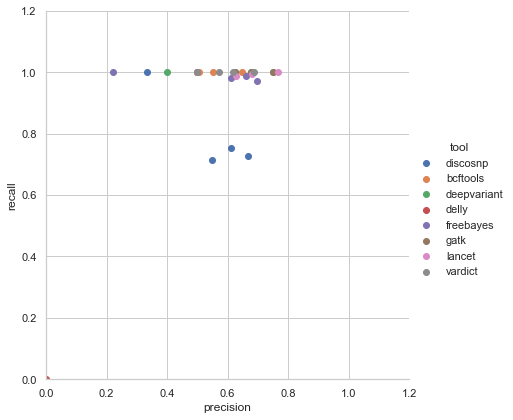

In [111]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=smallindels_df, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

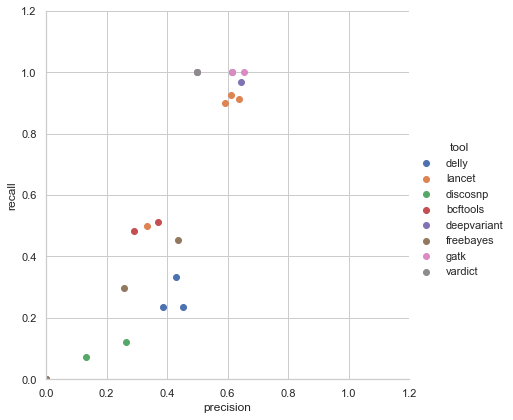

In [112]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=medindels_df, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### Indels only - NO coverage filter

In [115]:
stats_nocov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/cov_limit_0/20210615_all_indels_cov0.csv', header=None)

In [116]:
stats_nocov.rename(columns={0: 'file_prefix', 1: 'true_pos', 2: 'false_pos', 3: 'false_neg', 4: 'precision', 5: 'recall'}, inplace=True)
stats_nocov.loc[stats_nocov['recall'] == '.' , 'recall'] = np.nan
stats_nocov.loc[stats_nocov['precision'] == '.' , 'precision'] = np.nan
stats_nocov['recall'] = pd.to_numeric(stats_nocov['recall'])
stats_nocov['precision'] = pd.to_numeric(stats_nocov['precision'])

In [117]:
stats_nocov['true_pos'] = pd.to_numeric(stats_nocov['true_pos'])
stats_nocov['false_pos'] = pd.to_numeric(stats_nocov['false_pos'])
stats_nocov['false_neg'] = pd.to_numeric(stats_nocov['false_neg'])

In [118]:
stats_nocov['dataset'] = [name.split('_')[0] for name in stats_nocov['file_prefix']]
stats_nocov['tool'] = [name.split('_')[-2] for name in stats_nocov['file_prefix']]
stats_nocov.loc[stats_nocov['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_nocov.loc[stats_nocov['tool'] == 'normalized',:]['file_prefix']]
stats_nocov.loc[stats_nocov['tool'] == 'normalized', 'tool'] = [name.split('_')[-3].split('-')[0] for name in stats_nocov.loc[stats_nocov['tool'] == 'normalized',:]['file_prefix']]
stats_nocov['num_snp'] = [int(num_snp[ds]) for ds in stats_nocov['dataset']]
stats_nocov['num_indel'] = [int(num_indel[ds]) for ds in stats_nocov['dataset']]
stats_nocov['total_mutations'] = stats_nocov['num_snp'] + stats_nocov['num_indel']
stats_nocov['low_cov_mutations_filtered'] = stats_nocov['total_mutations'] - stats_nocov['true_pos'] - stats_nocov['false_neg']

In [119]:
stats_nocov['filtered_total_mutations'] = stats_nocov['total_mutations'] - stats_nocov['low_cov_mutations_filtered']
stats_nocov['snp_density'] = stats_nocov['num_snp'] / 4411532
stats_nocov['indel_density'] = stats_nocov['num_indel'] / 4411532
stats_nocov['indel_snp_ratio'] = round(stats_nocov['num_indel']/stats_nocov['num_snp'], 2)

In [120]:
# remove duplicate tools
stats_nocov_noHC = stats_nocov[stats_nocov['tool'] != 'HaplotypeCaller']
stats_nocov_noduptools = stats_nocov_noHC[stats_nocov['tool'] != 'discosnp-edit']

In [121]:
stats_nocov_noduptools

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,3444,2,850,0.999420,0.802049,TEST-H37Rv10-3indels,discosnp,0,4294,4294,0,4294,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,4247,1020,47,0.806341,0.989054,TEST-H37Rv10-3indels,bcftools,0,4294,4294,0,4294,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,4249,10,45,0.997652,0.989520,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,0,4294,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,4294,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,0,4294,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,4199,53,95,0.987535,0.977876,TEST-H37Rv10-3indels,freebayes,0,4294,4294,0,4294,0.0,9.733580e-04,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,TEST-H37Rv10-6medindels_mq10_delly_normalized,2,0,2,1.000000,0.500000,TEST-H37Rv10-6medindels,delly,0,4,4,0,4,0.0,9.067145e-07,inf
58,TEST-H37Rv10-6medindels_mq10_freebayes_normalized,2,2,2,0.500000,0.500000,TEST-H37Rv10-6medindels,freebayes,0,4,4,0,4,0.0,9.067145e-07,inf
59,TEST-H37Rv10-6medindels_mq10_gatk_normalized,4,0,0,1.000000,1.000000,TEST-H37Rv10-6medindels,gatk,0,4,4,0,4,0.0,9.067145e-07,inf
60,TEST-H37Rv10-6medindels_mq10_lancet_normalized,3,0,1,1.000000,0.750000,TEST-H37Rv10-6medindels,lancet,0,4,4,0,4,0.0,9.067145e-07,inf


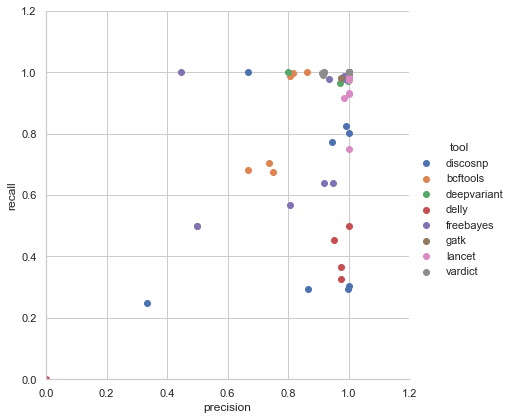

In [122]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_nocov_noduptools, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

In [123]:
smallindels_df_nocov = stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[0]]
smallindels_df_nocov = pd.concat([smallindels_df_nocov, stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[1]],
                           stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[2]], stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == smallindels[3]]])
smallindels_df_nocov

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
0,TEST-H37Rv10-3indels_discosnp-edit_normalized_...,3444,2,850,0.999420,0.802049,TEST-H37Rv10-3indels,discosnp,0,4294,4294,0,4294,0.0,9.733580e-04,inf
1,TEST-H37Rv10-3indels_mq10_bcftools_normalized,4247,1020,47,0.806341,0.989054,TEST-H37Rv10-3indels,bcftools,0,4294,4294,0,4294,0.0,9.733580e-04,inf
2,TEST-H37Rv10-3indels_mq10_deepvariant_normaliz...,4249,10,45,0.997652,0.989520,TEST-H37Rv10-3indels,deepvariant,0,4294,4294,0,4294,0.0,9.733580e-04,inf
3,TEST-H37Rv10-3indels_mq10_delly_normalized,0,0,4294,NaN,0.000000,TEST-H37Rv10-3indels,delly,0,4294,4294,0,4294,0.0,9.733580e-04,inf
4,TEST-H37Rv10-3indels_mq10_freebayes_normalized,4199,53,95,0.987535,0.977876,TEST-H37Rv10-3indels,freebayes,0,4294,4294,0,4294,0.0,9.733580e-04,inf
5,TEST-H37Rv10-3indels_mq10_gatk_normalized,4254,0,40,1.000000,0.990685,TEST-H37Rv10-3indels,gatk,0,4294,4294,0,4294,0.0,9.733580e-04,inf
6,TEST-H37Rv10-3indels_mq10_lancet_normalized,4188,0,106,1.000000,0.975314,TEST-H37Rv10-3indels,lancet,0,4294,4294,0,4294,0.0,9.733580e-04,inf
7,TEST-H37Rv10-3indels_mq10_vardict_normalized,4254,389,40,0.916218,0.990685,TEST-H37Rv10-3indels,vardict,0,4294,4294,0,4294,0.0,9.733580e-04,inf
15,TEST-H37Rv10-4indels_discosnp-edit_normalized_...,362,3,77,0.991781,0.824601,TEST-H37Rv10-4indels,discosnp,0,439,439,0,439,0.0,9.951192e-05,inf
16,TEST-H37Rv10-4indels_mq10_bcftools_normalized,438,98,1,0.817164,0.997722,TEST-H37Rv10-4indels,bcftools,0,439,439,0,439,0.0,9.951192e-05,inf


In [124]:
medindels_df_nocov = stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[0]]
medindels_df_nocov = pd.concat([medindels_df_nocov, stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[1]],
                           stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[2]], stats_nocov_noduptools[stats_nocov_noduptools['dataset'] == medindels[3]]])
medindels_df_nocov

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_density,indel_snp_ratio
8,TEST-H37Rv10-3medindels_discosnp-edit_normaliz...,1269,3,3037,0.997642,0.294705,TEST-H37Rv10-3medindels,discosnp,0,4306,4306,0,4306,0.0,9.760782e-04,inf
9,TEST-H37Rv10-3medindels_mq10_bcftools_normalized,3029,1082,1277,0.736804,0.703437,TEST-H37Rv10-3medindels,bcftools,0,4306,4306,0,4306,0.0,9.760782e-04,inf
10,TEST-H37Rv10-3medindels_mq10_deepvariant_norma...,4159,120,147,0.971956,0.965862,TEST-H37Rv10-3medindels,deepvariant,0,4306,4306,0,4306,0.0,9.760782e-04,inf
11,TEST-H37Rv10-3medindels_mq10_delly_normalized,1571,39,2735,0.975776,0.364840,TEST-H37Rv10-3medindels,delly,0,4306,4306,0,4306,0.0,9.760782e-04,inf
12,TEST-H37Rv10-3medindels_mq10_freebayes_normalized,2750,250,1556,0.916667,0.638644,TEST-H37Rv10-3medindels,freebayes,0,4306,4306,0,4306,0.0,9.760782e-04,inf
13,TEST-H37Rv10-3medindels_mq10_gatk_normalized,4228,113,78,0.973969,0.981886,TEST-H37Rv10-3medindels,gatk,0,4306,4306,0,4306,0.0,9.760782e-04,inf
14,TEST-H37Rv10-3medindels_mq10_lancet_normalized,3945,59,361,0.985265,0.916163,TEST-H37Rv10-3medindels,lancet,0,4306,4306,0,4306,0.0,9.760782e-04,inf
23,TEST-H37Rv10-4medindels_discosnp-edit_normaliz...,133,0,306,1.000000,0.302961,TEST-H37Rv10-4medindels,discosnp,0,439,439,0,439,0.0,9.951192e-05,inf
24,TEST-H37Rv10-4medindels_mq10_bcftools_normalized,297,99,142,0.750000,0.676538,TEST-H37Rv10-4medindels,bcftools,0,439,439,0,439,0.0,9.951192e-05,inf
25,TEST-H37Rv10-4medindels_mq10_deepvariant_norma...,427,1,12,0.997664,0.972665,TEST-H37Rv10-4medindels,deepvariant,0,439,439,0,439,0.0,9.951192e-05,inf


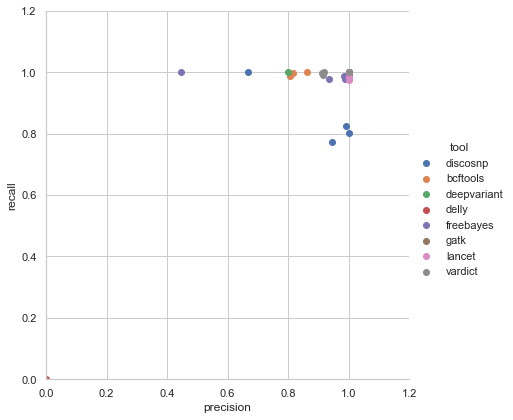

In [125]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=smallindels_df_nocov, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

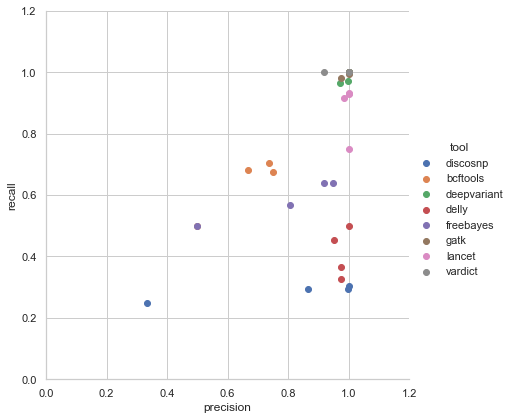

In [126]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=medindels_df_nocov, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

### All variants

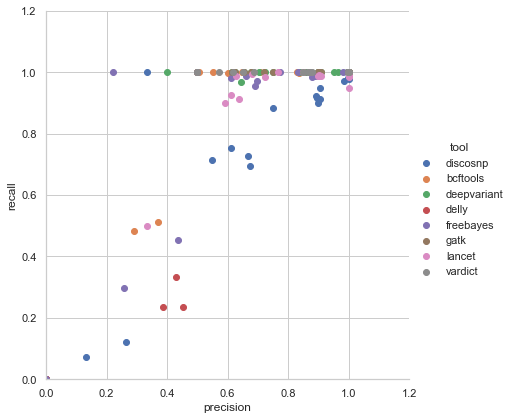

In [114]:
# https://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_noduptools, hue='tool', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

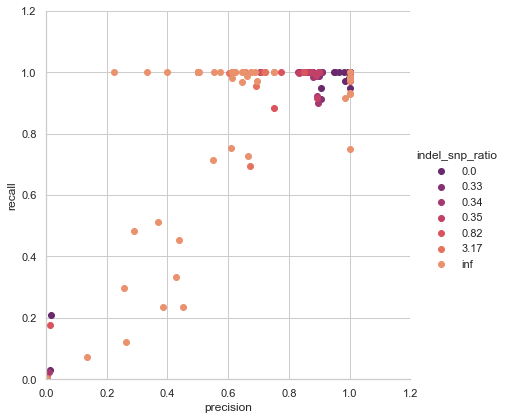

In [50]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=stats_noHC, hue='indel_snp_ratio', palette='flare_r', height=6, aspect=1, xlim=(0,1.2), ylim=(0,1.2))
fg.map(plt.scatter, 'precision', 'recall').add_legend()

In [69]:
snps_vs_indels = pd.concat([stats_SNPonly, stats_indelonly])

In [70]:
snps_vs_indels['type'] = ''
snps_vs_indels.loc[snps_vs_indels['num_indel'] == 0, 'type'] = 'SNP'
snps_vs_indels.loc[snps_vs_indels['num_indel'] > 0, 'type'] = 'indel'

In [71]:
snps_vs_indels['mutation_density'] = np.nan
snps_vs_indels.loc[snps_vs_indels['type'] == 'SNP', 'mutation_density'] = [dens for dens in snps_vs_indels.loc[snps_vs_indels['type'] == 'SNP',:]['snp_density']]
snps_vs_indels.loc[snps_vs_indels['type'] == 'indel', 'mutation_density'] = [denct for denct in snps_vs_indels.loc[snps_vs_indels['type'] == 'indel', :]['indel_density']]

In [72]:
snps_vs_indels

,file_prefix,true_pos,false_pos,false_neg,precision,recall,dataset,tool,num_snp,num_indel,total_mutations,low_cov_mutations_filtered,filtered_total_mutations,snp_density,indel_snp_ratio,indel_density,type,mutation_density
56,TEST-H37Rv20003snps_discosnp-edit_normalized_P...,19354,12,432,0.999380,0.978166,TEST-H37Rv20003snps,discosnp,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
58,TEST-H37Rv20003snps_mq10_bcftools_normalized,19786,23,0,0.998839,1.000000,TEST-H37Rv20003snps,bcftools,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
59,TEST-H37Rv20003snps_mq10_deepvariant_normalize...,19786,21,0,0.998940,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
60,TEST-H37Rv20003snps_mq10_deepvariant_normalized,19758,54,0,0.997274,1.000000,TEST-H37Rv20003snps,deepvariant,20003,0,20003,245,19758,0.004534,0.0,0.0,SNP,0.004534
61,TEST-H37Rv20003snps_mq10_delly_normalized,0,0,19786,NaN,0.000000,TEST-H37Rv20003snps,delly,20003,0,20003,217,19786,0.004534,0.0,0.0,SNP,0.004534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,TEST-MTBREF_mq10_delly_normalized,0,0,0,NaN,NaN,TEST-MTBREF,delly,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
107,TEST-MTBREF_mq10_freebayes_normalized,0,5,0,0.000000,NaN,TEST-MTBREF,freebayes,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
109,TEST-MTBREF_mq10_gatk_normalized,0,0,0,NaN,NaN,TEST-MTBREF,gatk,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000
110,TEST-MTBREF_mq10_lancet_normalized,0,0,0,NaN,NaN,TEST-MTBREF,lancet,0,0,0,0,0,0.000000,NaN,0.0,SNP,0.000000


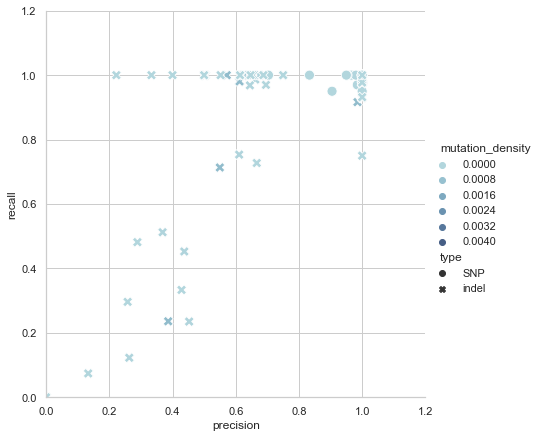

In [73]:
fg = seaborn.relplot(data=snps_vs_indels, x='precision', y='recall', hue='mutation_density', palette='ch:r=-.2,d=.3,l=.8', style='type', height=6, aspect=1, s=100)
fg.set(xlim=(0, 1.2), ylim=(0, 1.2))